# Individual Assignment - Submission

> - **Course:** *CE/CZ 4042 - Neural Networks and Deep Learning* 
> - **Name:** *Singh Aishwarya*
> - **Matriculation Number:** *U1923952C*
> - **Part:** *B - Regression Problem*
> - **Question:** *1*

### Necessary Imports + Environment Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup
import pandas as pd
from tensorflow.keras import metrics
import pydot
import graphviz
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.python.keras.metrics import Metric
import tensorflow as tf
from keras import backend as K

### Data Retrieval + Defining Important Functions

In [5]:
df = pd.read_csv('/content/drive/MyDrive/CE4042/assignment/hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [6]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


### Model Training - Answering the question

> **Question:** *Real world datasets often contain a mix of numeric and categorical features–this dataset is one such example. Modelling such a mix of feature types with neural networks requires some modifications to the input layer.*

#### a) Divide the dataset (‘HDB_price_prediction.csv’) into train and test sets by using entries from year 2020 and before as training data (with the remaining data from year 2021 used as test data). Why is this done instead of random train/test splits?

In [7]:
# Split into train and test datasets based on the condition given
train_dataframe = df[df['year'] <= 2020] 
test_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

# Create Batches
train_ds = train_ds.batch(128)
test_ds = test_ds.batch(128)

> **Why?** *A test dataset's actual goal is to estimate how well a classifier will perform in future production scenarios. We do not test the classifier on training data because training error has a large unwanted upward score bias: it is simple to identify classifiers that perform well on training but do not perform well on future data. The error on test data — data that the classifier has never seen before — is intended to provide a more accurate prediction of the model's future performance. The fundamental assumption of adopting a random test/train split is that future data is interchangeable with past data: that is, the relevant variables will be distributed in the same way, such that training data is a good estimate of test data — and test data is a good estimate of future data. However, owing to time constraints, the data is not exchangeable in many fields (in this HDB example). In these cases, a random test/train split will result in test data that is too similar to the training data and not enough like future data. This has the effect of making a classifier appear better than it is, so you can't be certain that your testing method has removed faulty classifiers. In fact, you may unintentionally remove a good classifier in favor of a weaker one that outperforms it in this simulated circumstance.*

#### b) Design  a 2-layer  feedforward  neural  network consisting of an input layer, a hidden layer (10 neurons, ReLU as activation function), and a linear output layer. One-hot encoding should be applied to  categorical  features  and  numeric  features  are  standardised.  After encoding / standardisation, the input features should be concatenated. 

In [8]:
# One-hot encoding + Standardization of features

# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

all_inputs = [
    month,
    flat_model_type,
    storey_range,
    floor_area_sqm,
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years
]

all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        floor_area_sqm_encoded,
        dist_to_nearest_stn_encoded,
        storey_range_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
    ]
)

In [9]:
# Define R2 Score
def r2Score(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

#### c) On the training data, train the model for 100 epochs using mini-batch gradient descent with batch size = 128, Use ‘adam’ optimiser with a learning rate of 𝛼 = 0.05 and mean square error as cost function

In [10]:
# Feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

In [11]:
# Build the model
model = keras.Model(all_inputs, output)
opt = keras.optimizers.Adam(learning_rate=0.05)
model.compile(optimizer=opt,
              loss='mse',
              metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse'), r2Score])

In [12]:
# Summarise the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
flat_model_type (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
floor_area_sqm (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
dist_to_nearest_stn (InputLayer [(None, 1)]          0                                            
______________________________________________________________________________________________

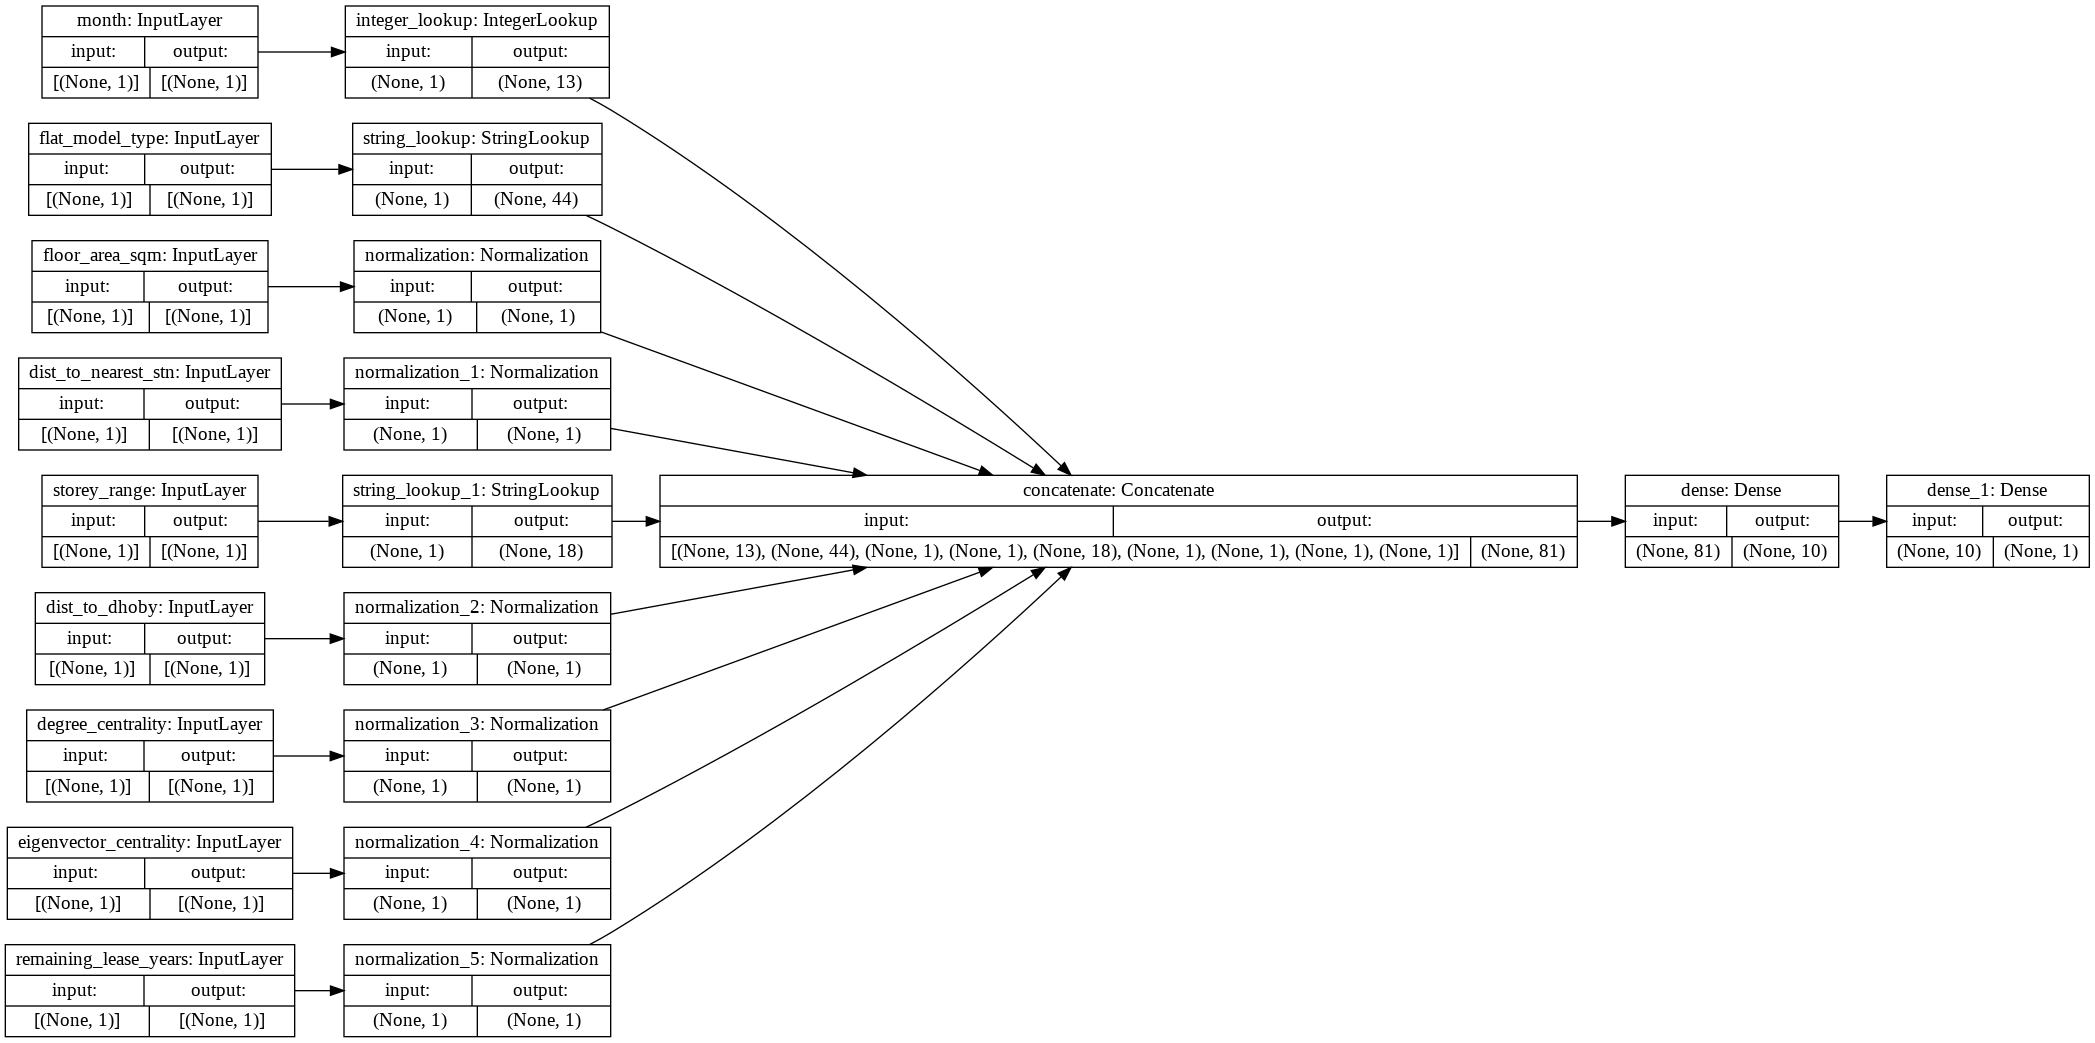

In [13]:
# Visualise the model
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [15]:
# Training the model - Introducing Callback

checkpoint_filepath = '/content/drive/MyDrive/CE4042/assignment/Checkpoint/model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_rmse',
    mode='min',
    save_best_only=True)

history = model.fit(train_ds, 
                    epochs=100, 
                    batch_size=128,
                    callbacks=[model_checkpoint_callback], 
                    validation_data=test_ds)

Epoch 1/100
683/683 [==============================] - 3s 4ms/step - loss: 67256442880.0000 - rmse: 259338.4688 - r2Score: -1.8819 - val_loss: 39849705472.0000 - val_rmse: 199623.9062 - val_r2Score: -0.5514
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 10812144640.0000 - rmse: 103981.4609 - r2Score: 0.5404 - val_loss: 11018702848.0000 - val_rmse: 104970.0078 - val_r2Score: 0.5743
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 5549173760.0000 - rmse: 74492.7734 - r2Score: 0.7636 - val_loss: 8586063872.0000 - val_rmse: 92661.0156 - val_r2Score: 0.6685
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 5006125568.0000 - rmse: 70753.9766 - r2Score: 0.7865 - val_loss: 8100270080.0000 - val_rmse: 90001.5000 - val_r2Score: 0.6865
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 4636574208.0000 - rmse: 68092.3984 - r2Score: 0.8025 - val_loss: 7596423168.0000 - val_rmse: 87157.4609 - val_r

#### d) Plot the train and test root mean square errors (RMSE) against epochs.

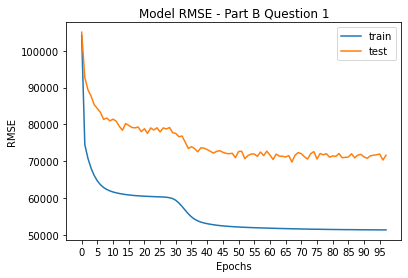

In [ ]:
# Plotting the Model RMSE
plt.plot(history.history['rmse'][2:])
plt.plot(history.history['val_rmse'][2:])
plt.title('Model RMSE - Part B Question 1')
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.xticks([x for x in range(0, 100, 5)])
plt.legend(['train', 'test'], loc='best')
plt.savefig('./Figures/PartBQuestion1-1.png')

#### e) State the epoch with the lowest test error. State the test R2 value at that epoch.

In [17]:
print("Epoch: 100")
print("RMSE:", min(history.history['rmse']))
print("R2 Score:", max(history.history['r2Score']))

Epoch: 100
RMSE: 51233.04296875
R2 Score: 0.8872498273849487


> **Epoch with lowest R2 Score:** *100*

> **Corresponding R2 Score:** *0.8872498273849487*


In [18]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

#### f) Using the model from that best epoch, plot the predicted values and target values for a batch of 128 test samples.

In [19]:
# Loading the model with the best saved epoch
loadModel = keras.Model(all_inputs, output)
loadModel.load_weights("/content/drive/MyDrive/CE4042/assignment/Checkpoint/model")
loadModel.compile(optimizer=opt,
              loss='mse',
              metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse'), r2Score])

In [20]:
import random
random_batch = random.randint(0,131)
print(random_batch)
i = 0
for batch in test_ds:
  if(i == random_batch):
    rand_batch = batch
  i += 1
print(rand_batch)

28
({'month': <tf.Tensor: shape=(128,), dtype=int64, numpy=
array([7, 3, 4, 3, 1, 6, 4, 2, 4, 6, 1, 4, 6, 1, 6, 5, 6, 2, 7, 4, 2, 6,
       1, 8, 5, 5, 5, 8, 1, 3, 1, 1, 6, 6, 3, 4, 5, 8, 4, 6, 5, 1, 1, 4,
       7, 3, 4, 5, 7, 6, 1, 3, 1, 3, 7, 8, 7, 1, 1, 2, 2, 5, 6, 1, 3, 1,
       5, 4, 6, 8, 2, 7, 6, 7, 1, 6, 7, 3, 3, 4, 2, 1, 2, 5, 6, 5, 3, 2,
       3, 2, 7, 7, 3, 7, 1, 4, 4, 1, 1, 3, 4, 4, 2, 4, 4, 7, 6, 7, 7, 1,
       2, 1, 1, 4, 1, 7, 1, 5, 6, 2, 3, 4, 1, 6, 6, 1, 6, 5])>, 'year': <tf.Tensor: shape=(128,), dtype=int64, numpy=
array([2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021,
       2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021,
       2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021,
       2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021,
       2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021,
       2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021,
       2021, 2021, 

In [21]:
# Predict the output 
y_pred = loadModel.predict(rand_batch[0])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


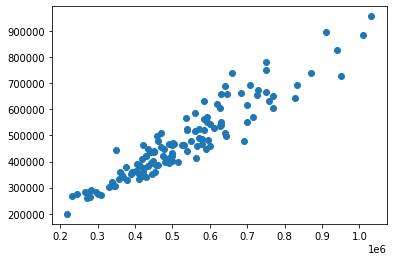

In [22]:
# Plot the predictions
plt.scatter(rand_batch[1], y_pred)